<a href="https://colab.research.google.com/github/sriharsha1718/LangGraph/blob/main/09_Drafter_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q langchain_groq

In [2]:
from typing import TypedDict, Sequence, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

In [3]:
GROQ_API_KEY = 'gsk_xxxxxxxxxxxxxxxxxxxxx'

In [4]:
### This is the global variable
document_content = ''

class AgentState(TypedDict):
  messages : Annotated[Sequence[BaseMessage], add_messages]


#It is important to have a doc string for LLM to understand the tool functionality
@tool
def update(content : str) -> str:
  """Updates the document with the provided content"""
  global document_content
  document_content = content
  return f"Document has been updated sucessfully! The current content is {document_content}"

@tool
def save(filename : str) -> str:
  """Saves the current document into a text file and finishes the process
     Args :
          filename : Name for the text file.
  """
  global document_content

  #This is just to make it robust
  if not filename.endswith('.txt'):
    filename = f"{filename}.txt"


  try:
    with open(filename, 'w') as file:
      file.write(document_content)
    print(f"The document has been saved to : {filename}")
    return f"The document has been saved to : {filename}"
  except Exception as e:
    return f"Error saving the file : {str(e)}"


tools  = [update, save]

model = ChatGroq(
    model="llama-3.1-8b-instant", temperature=0,
    api_key=GROQ_API_KEY
).bind_tools(tools)

In [5]:
### This is our Node and the logic
def our_agent(state : AgentState) -> AgentState:
  system_prompt = SystemMessage(
      content = f"""
      You are a Drafter, a helpful writing assistant. You are going to help the user update and modify documents.

      - If the user wants to update or modify the content, use the 'update' tool
      - If the user wants to save the document and finish the process, use the 'save' tool
      - Make sure to always show the current document state after modifications

      The current document content is:


      {document_content}
      """
  )

  # To make it more robust if the state messages are empty
  if not state['messages']:
    user_input = 'Can you help me draft a mail?'
    user_message = HumanMessage(content=user_input)
  else:
    user_input = input("\nWhat would you like to do with the document? ")
    print(f"\nUser: {user_input}")
    user_message = HumanMessage(content=user_input)

  all_messages = [system_prompt] + list(state['messages']) + [user_message]

  response = model.invoke(all_messages)

  print(f"\nAI: {response.content}")
  if hasattr(response, "tool_calls") and response.tool_calls:
    print(f" Using Tools: {[tc['name'] for tc in response.tool_calls]}")

  return {'messages' : list(state['messages']) + [user_message, response]}


### This logic is for conditional edge
def should_continue(state : AgentState) -> str:
  """Determine if we should continue or end the conversation"""
  messages = state['messages']
  if not messages:
    return 'continue'

  # This looks for the most recent tool message
  for message in reversed(messages):
      # checks if this is a ToolMessage resulting from save
      if (isinstance(message, ToolMessage) and
          "saved" in message.content.lower() and "document" in message.content.lower()):
          return "end"

  return "continue"

In [6]:
def print_messages(messages):
    """Function I made to print the messages in a more readable format"""
    if not messages:
        return

    for message in messages[-3:]:
        if isinstance(message, ToolMessage):
            print(f"\n Tool Result: {message.content}")

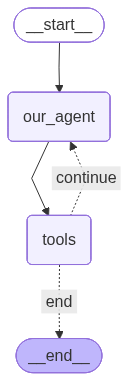

None


In [7]:
graph = StateGraph(AgentState)

graph.add_node('our_agent', our_agent)
graph.add_node('tools', ToolNode(tools))

graph.add_edge(START, 'our_agent')
graph.add_edge('our_agent', 'tools')

graph.add_conditional_edges(
    'tools',
    should_continue,
    {
        'continue' : 'our_agent',
        'end' : END
    }
)

app = graph.compile()

from IPython.display import display, Image
print(display(Image(app.get_graph().draw_mermaid_png())))

In [8]:
def run_document_agent():
    print("\n ===== Drafter =====")

    state = {"messages": []}

    for step in app.stream(state, stream_mode="values"):
        if "messages" in step:
            print_messages(step["messages"])

    print("\n ===== Drafter Finished =====")

if __name__ == "__main__":
    run_document_agent()


 ===== Drafter =====

AI: The current document content is: 

Dear [Recipient],

This is a draft mail.

Best regards,
[Your Name]


 Using Tools: ['update']

 Tool Result: Document has been updated sucessfully! The current content is Dear John,

This is a draft mail.

Best regards,
[Your Name]

What would you like to do with the document? Hey could you help me to draft a mail to my manager Naveen saying I wont be able to attend today meeting

User: Hey could you help me to draft a mail to my manager Naveen saying I wont be able to attend today meeting

AI: 
 Using Tools: ['update']

 Tool Result: Document has been updated sucessfully! The current content is Dear John,

This is a draft mail.

Best regards,
[Your Name]

 Tool Result: Document has been updated sucessfully! The current content is Dear Naveen,

I regret to inform you that I won't be able to attend today's meeting.

Best regards,
[Your Name]

What would you like to do with the document? Pls also include the time which is 10 